# Imports

Please note that this page is still being cleaned. I apologize for some of the messiness

In [1]:
import sys
import pprint
import json
import numpy as np
import pandas as pd
from dateutil.parser import parse
from pymongo import MongoClient
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim.summarization.summarizer import summarize
from numpy.linalg import norm
#from scipy.sparse.csc_matrix import transpose

#import seaborn as sns
%matplotlib inline


print("python Version:", sys.version)

python Version: 3.5.2 |Anaconda 4.2.0 (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
!python --version

Python 3.5.2 :: Anaconda 4.2.0 (64-bit)


# Db Config

In [3]:
client = MongoClient()
db = client.presidents
paragraphs = db.submissions
full_speeches = db.fullspeeches

In [4]:
# speeches.delete_many({})

In [5]:
# with open('/home/karlrudeen/presidentialspeeches9.json', encoding='utf-8') as data_file:    
#     data = json.load(data_file)
#     speeches.insert_many(data)

In [6]:
paragraphs.count()

21968

In [7]:
full_speeches.count()

960

It is worth looking at our speech data on the speech level, and the paragraph within speech model. Speeches tend to cover a wide range of subjects, so when it comes to topic modeling, it may make more sense to model on individual paragraphs within speeches.

In [10]:
par_list = []

for par in paragraphs.find():
    #pprint.pprint(speech)
    if len(par['text']) > 140:
        par['text'] = par['text'].replace('</p>',' ').lower()
        par_list.append(par)
    
#     speech_text.append(speech['text'].replace('<p>', '').\
#                        replace('(Applause.)',' ').replace('(applause)','').replace('inaudible','').split('<br>'))

In [12]:
df_pars = pd.DataFrame(par_list)

In [13]:
fullspeech_list = []

for fullspeech in full_speeches.find():
    if len(fullspeech['text']) > 500:
        fullspeech['text'] = fullspeech['text'].replace('\n',' ').lower()
        fullspeech_list.append(fullspeech)

In [14]:
df_full_speeches = pd.DataFrame(fullspeech_list)

In [15]:
def num_freqs_tup(ser):
    #find 
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [16]:
def series_to_list(ser):
    return list(ser.tolist())

# NMF

The idea here is to do a grid search on varying levels of maximum document frequency (max_df) and number of topics (n_comps). The lower max_df is, the fewer words are included in the data.

I want to find a combination of n_comps and max_df that gives each president his own signature topic. I need some way to quantify how well the algorithm has done in this regard, so I created a metric. I call the metric Favorite Topic Frequency (FTF). The formula for FTF is FTF = t/s, where t is the total count of speeches by that president that fall under that presidents most frequent topic, and s is the total number of speeches given by that topic.

In [17]:
def num_freqs_tup(ser):
    arr1 = ser.tolist()
    m = max([arr1.count(a) for a in arr1])
    return (m,len(arr1))

In [18]:
# #code below commented out because it takes forever to load. Pickles are here instead/

# import pickle

# with open('par_data.pkl', 'wb') as picklefile:
#     pickle.dump(speech_stats, picklefile)

# with open('speech_data.pkl', 'wb') as picklefile:
#     pickle.dump(full_speech_stats, picklefile)

In [19]:
with open("par_data.pkl", 'rb') as picklefile: 
    speech_stats = pickle.load(picklefile)

with open("speech_data.pkl", 'rb') as picklefile: 
    full_speech_stats = pickle.load(picklefile)

In [20]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [5,10,20,30,40]
# speech_stats =[]

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_pars['text'])

#         counts = tfidf_vectorizer.transform(df_pars['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_pars['NMF_topic_num'] = doc_cluster

#         tups = df_pars.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
        
#         speech_stats.append((n_comp, freq, metricthing))

Data with paragraphs as documents

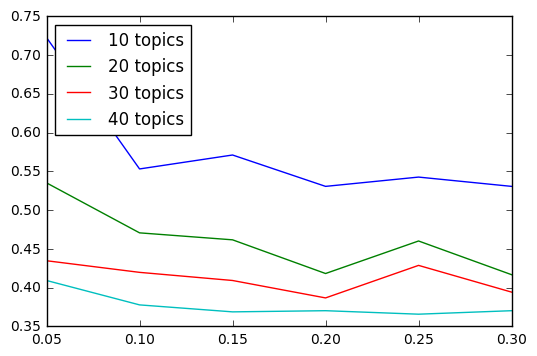

In [21]:
nums_tens = [(num[1],num[2]) for num in speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [22]:
# fullspeech_list = []

# for fullspeech in full_speeches.find():
#     if len(fullspeech['text']) > 500:
#         fullspeech['text'] = fullspeech['text'].replace('\n',' ')
#         fullspeech_list.append(fullspeech)

In [23]:
# df_full_speeches = pd.DataFrame(fullspeech_list)

In [24]:
# max_dfs = [.05, .10, .15, .20, .25, .30]
# n_comps = [10,20,30,40]
# full_speech_stats = []

# for freq in max_dfs:
#     for n_comp in n_comps:
#         tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
#                         stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", max_df = freq)
#         tfidf_vectorizer.fit(df_full_speeches['text'])

#         counts = tfidf_vectorizer.transform(df_full_speeches['text'])
#         id2word = dict((v, k) for k, v in tfidf_vectorizer.vocabulary_.items())
#         model = NMF(n_components=n_comp, init='random', random_state=0)
#         doc_topics = model.fit_transform(counts)

#         doc_cluster = [list(r).index(max(r)) for r in doc_topics]
#         df_full_speeches['NMF_topic_num'] = doc_cluster

#         tups = df_full_speeches.groupby('president').agg({
#             'NMF_topic_num': num_freqs_tup
#             })['NMF_topic_num']
#         metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

#         full_speech_stats.append((n_comp,freq,metricthing))

data with full speeches as documents

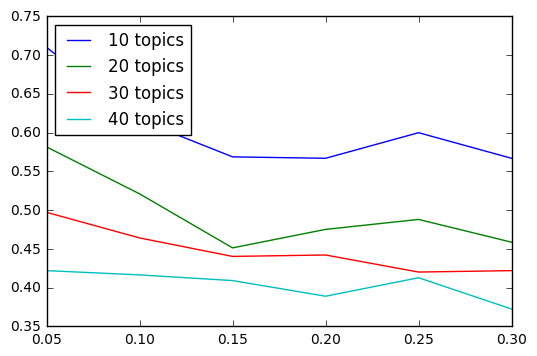

In [25]:
nums_tens = [(num[1],num[2]) for num in full_speech_stats if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in full_speech_stats if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


There are a few takeaways here. First note that FTF goes down as max_df goes up. Second, there isn't that much difference in FTF between full_speeches and paragraphs. All things being equal, it is good to improve granularity, so I think it is best to use paragraphs as my documents. Now, using the graph as a guide, I will look at the topic words of a few different combination of max_df and number of topics.

In [26]:
def mode(arr):
    arr = [num for num in arr if num !=-1]
    m = max([arr.count(a) for a in arr])
    return [x for x in arr if arr.count(x) == m][0] if m>0 else None

In [27]:
def average_tuples(ser):
    mylist = ser.tolist()
    return [np.mean(tup) for tup in list(zip(*mylist))]

In [28]:
def my_count(arr, thing_to_count):
    return arr.count(thing_to_count)/len([num for num in arr if num !=-1])

In [39]:
def create_topics(n_comp, freq_full):
    tfidf_vectorizer_par = TfidfVectorizer(ngram_range=(1, 2),  
                            stop_words='english', token_pattern="\\b[a-z][a-z]+\\b", min_df = 5, max_df = freq_full)
    tfidf_vectorizer_par.fit(df_pars['text'])

    counts_par = tfidf_vectorizer_par.transform(df_pars['text'])
    id2word = dict((v, k) for k, v in tfidf_vectorizer_par.vocabulary_.items())

    model = NMF(n_components=n_comp, init='random', random_state=0)
    model.fit(counts_par)
    par_topics = model.transform(counts_par)
    doc_cluster = [list(r).index(max(r)) for r in par_topics]

    df_pars['NMF_topic_num'] = doc_cluster
    tups = df_pars.groupby('president').agg({
             'NMF_topic_num': num_freqs_tup
             })['NMF_topic_num']
    FTF = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])
    topic_words = []
    for r in model.components_:
        a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
        topic_words.append([id2word[e[1]] for e in a])
        
    return {'topic_words': topic_words, 'par_topics': par_topics, 'FTF': FTF}

In [88]:
topic_dict = create_topics(46,.05)

In [89]:
topic_dict['topic_words']

[['duty', 'executive', 'subject', 'authority', 'question', 'powers', 'duties'],
 ['house',
  'representatives',
  'senate',
  'house representatives',
  'resolution',
  'passed',
  'return'],
 ['tax', 'income', 'taxes', 'percent', 'budget', 'deficit', 'cut'],
 ['man', 'life', 'spirit', 'liberty', 'earth', 'woman', 'like'],
 ['let', 'say', 'let say', 'remember', 'let remember', 'forward', 'let begin'],
 ['help', 'support', 'ask', 'need help', 'help help', 'welfare', 'program'],
 ['examination',
  'place',
  'commission',
  'person',
  'test',
  'fitness',
  'test fitness'],
 ['thank',
  'thank thank',
  'welcome',
  'senator',
  'members',
  'want thank',
  'congressman'],
 ['think',
  'don',
  'things',
  'don think',
  'republicans',
  'american people',
  'agree'],
 ['service',
  'classified',
  'civil service',
  'civil',
  'officers',
  'public service',
  'classified service'],
 ['history', 'hope', 'faith', 'past', 'common', 'progress', 'century'],
 ['treaty', 'chinese', 'article'

In [57]:
topic_words = []
for r in model.components_:
    a = sorted([(v,i) for i,v in enumerate(r)],reverse=True)[0:7]
    topic_words.append([id2word_full[e[1]] for e in a])

In [81]:
topic_words

NameError: name 'topic_words' is not defined

In [96]:
par_cluster = [list(r).index(max(r)) if max(list(r)) > .002 else -1 for r in topic_dict['par_topics']]

In [97]:
full_cluster.count(-1)/len(full_cluster)

NameError: name 'full_cluster' is not defined

In [98]:
par_cluster.count(-1)/len(topic_dict['par_topics'])

0.0

In [99]:
df_full_speeches['NMF_topic_num'] = full_cluster
df_full_speeches['NMF_topic_amts'] = [tuple(doc) for doc in full_topics]

NameError: name 'full_cluster' is not defined

In [100]:
df_pars['NMF_topic_num'] = par_cluster

In [101]:
df_pars['NMF_topic_amts'] = [tuple(doc) for doc in topic_dict['par_topics']]

In [102]:
# okeything = df_full_speeches.groupby('president').agg({
#     'NMF_topic_num': num_freqs_tup,
#     'NMF_topic_amts' : average_tuples
#     })['NMF_topic_num']

tups = df_pars.groupby('president').agg({
    'NMF_topic_num': num_freqs_tup
    })['NMF_topic_num']
metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

In [103]:
df_pars

,_id,date,president,text,title,NMF_topic_num,NMF_topic_amts
0,58b34cbbcb3bb02c032a702a,"January 21, 2013",Barack Obama,each time we gather to inaugurate a president ...,"Second Inaugural Address (January 21, 2013)",22,"(0.0, 0.0, 0.000547006011056, 0.00242860367332..."
1,58b34cbbcb3bb02c032a702b,"January 21, 2013",Barack Obama,"“we hold these truths to be self-evident, that...","Second Inaugural Address (January 21, 2013)",42,"(0.0, 0.0, 0.0, 0.0757249542891, 0.0, 0.000186..."
2,58b34cbbcb3bb02c032a702d,"January 21, 2013",Barack Obama,today we continue a never-ending journey to br...,"Second Inaugural Address (January 21, 2013)",10,"(0.0, 0.0, 0.0, 0.0202332301752, 0.00128540437..."
3,58b34cbbcb3bb02c032a7031,"January 21, 2013",Barack Obama,through blood drawn by lash and blood drawn by...,"Second Inaugural Address (January 21, 2013)",24,"(0.00486243725259, 0.0, 0.00224256145905, 0.00..."
4,58b34cbbcb3bb02c032a7033,"January 21, 2013",Barack Obama,"together, we determined that a modern economy ...","Second Inaugural Address (January 21, 2013)",39,"(0.0, 0.0, 0.00563274839474, 0.0, 0.0, 0.0, 0...."
5,58b34cbbcb3bb02c032a7039,"January 21, 2013",Barack Obama,"through it all, we have never relinquished our...","Second Inaugural Address (January 21, 2013)",0,"(0.0253402846806, 0.0, 0.0, 0.003123765506, 0...."
6,58b34cbbcb3bb02c032a703b,"January 21, 2013",Barack Obama,but we have always understood that when times ...,"Second Inaugural Address (January 21, 2013)",39,"(0.0119265377996, 0.0, 0.00452030887311, 0.0, ..."
7,58b34cbbcb3bb02c032a703d,"January 21, 2013",Barack Obama,this generation of americans has been tested b...,"Second Inaugural Address (January 21, 2013)",40,"(0.0, 0.0, 0.0, 0.0, 0.00128024018276, 0.0, 0...."
8,58b34cbbcb3bb02c032a703f,"January 21, 2013",Barack Obama,"for we, the people, understand that our countr...","Second Inaugural Address (January 21, 2013)",33,"(0.0, 0.0, 0.0120290666978, 0.010842011584, 0...."
9,58b34cbbcb3bb02c032a7041,"January 21, 2013",Barack Obama,we understand that outworn programs are inadeq...,"Second Inaugural Address (January 21, 2013)",2,"(0.0115783018774, 0.0, 0.104030308917, 0.00624..."


In [104]:
okeydoke = df_pars.groupby('president', as_index = False).agg({
    'NMF_topic_num': series_to_list,
    'NMF_topic_amts' : average_tuples
    })

In [105]:
okeydoke

,president,NMF_topic_amts,NMF_topic_num
0,Abraham Lincoln,"[0.0196992548253, 0.00635878299681, 0.00420866...","[12, 36, 0, 0, 6, 27, 42, 36, 27, 34, 30, 29, ..."
1,Andrew Jackson,"[0.0578439038121, 0.0351414132008, 0.003216247...","[1, 1, 0, 3, 42, 1, 0, 0, 1, 0, 12, 0, 0, 1, 0..."
2,Andrew Johnson,"[0.0308224966094, 0.0266563130799, 0.001275747...","[1, 32, 32, 32, 32, 0, 0, 0, 1, 1, 1, 1, 1, 14..."
3,Barack Obama,"[0.00157195417002, 0.00279772641265, 0.0186630...","[22, 42, 10, 24, 39, 0, 39, 40, 33, 2, 37, 38,..."
4,Benjamin Harrison,"[0.0167103588655, 0.00937628851712, 0.00218272...","[11, 43, 43, 8, 11, 29, 0, 23, 14, 21, 21, 21,..."
5,Bill Clinton,"[0.00213670616211, 0.00343248295774, 0.0163838...","[40, 19, 34, 42, 23, 19, 13, 34, 40, 22, 10, 1..."
6,Calvin Coolidge,"[0.0175606854863, 0.0034355500471, 0.000715670...","[28, 45, 44, 3, 29, 3, 39, 3, 3, 3, 17, 25, 3,..."
7,Chester A. Arthur,"[0.022307025892, 0.0131426959863, 0.0011009929...","[11, 11, 24, 34, 34, 27, 11, 11, 11, 11, 34, 3..."
8,Dwight D. Eisenhower,"[0.00584729953852, 0.00199370280472, 0.0015251...","[0, 16, 10, 34, 34, 34, 24, 24, 34, 34, 34, 34..."
9,Franklin D. Roosevelt,"[0.00533732565924, 0.0028376028595, 0.00443584...","[23, 0, 23, 45, 38, 34, 38, 22, 22, 1, 43, 22,..."


In [106]:
metricthing

0.17866594286489787

In [108]:
df_pars['date_obj'] = df_pars['date'].apply(parse)

In [109]:
for i in range(40):
    #okeydoke['topic_' + str(i)] = okeydoke['NMF_topic_num'].apply(lambda x: my_count(x,i))
    okeydoke['topic_amt_' + str(i)] = okeydoke['NMF_topic_amts'].apply(lambda x: x[i]/sum(x))

In [110]:
okeydoke.iloc[:,3:]

,topic_amt_0,topic_amt_1,topic_amt_2,topic_amt_3,topic_amt_4,topic_amt_5,topic_amt_6,topic_amt_7,topic_amt_8,topic_amt_9,...,topic_amt_30,topic_amt_31,topic_amt_32,topic_amt_33,topic_amt_34,topic_amt_35,topic_amt_36,topic_amt_37,topic_amt_38,topic_amt_39
0,0.116870,0.037725,0.024969,0.019927,0.008788,0.005014,0.020118,0.001551,0.013357,0.033539,...,0.007764,0.003894,0.009106,0.009576,0.049829,0.086236,0.008735,0.009859,0.007689,0.007812
1,0.276136,0.167759,0.015354,0.014704,0.005894,0.001862,0.011323,0.002580,0.006932,0.009138,...,0.001346,0.001549,0.036187,0.008045,0.004918,0.012639,0.004538,0.004466,0.009107,0.002941
2,0.158624,0.137183,0.006565,0.017562,0.008246,0.003221,0.030439,0.002275,0.005385,0.020907,...,0.001850,0.001557,0.044287,0.005691,0.009557,0.023601,0.007664,0.004320,0.003233,0.003280
3,0.007633,0.013585,0.090624,0.034001,0.039173,0.030006,0.007083,0.028738,0.055381,0.005049,...,0.036948,0.025823,0.013047,0.016080,0.010077,0.003788,0.023864,0.052817,0.020879,0.068276
4,0.101503,0.056954,0.013258,0.031302,0.008617,0.003905,0.026926,0.005197,0.018204,0.016390,...,0.004332,0.005051,0.017097,0.011650,0.039647,0.018305,0.006795,0.003758,0.007523,0.017435
5,0.009725,0.015622,0.074568,0.025895,0.056391,0.040458,0.008146,0.032783,0.031654,0.012079,...,0.009139,0.020247,0.007207,0.023710,0.015643,0.003948,0.032053,0.070001,0.020273,0.077713
6,0.085301,0.016688,0.003476,0.191804,0.017923,0.008232,0.015537,0.005287,0.013503,0.013796,...,0.007339,0.003539,0.010982,0.010147,0.029129,0.003495,0.032853,0.002008,0.008005,0.016442
7,0.137074,0.080760,0.006765,0.016343,0.002301,0.004427,0.011097,0.003223,0.010345,0.012520,...,0.004739,0.001440,0.010753,0.001940,0.078730,0.017778,0.008667,0.004437,0.005579,0.004756
8,0.038281,0.013052,0.009985,0.063178,0.034202,0.037477,0.012347,0.015800,0.010046,0.005687,...,0.028542,0.006099,0.004541,0.007844,0.083320,0.006545,0.055824,0.007954,0.055249,0.014150
9,0.035038,0.018628,0.029120,0.050472,0.028008,0.032581,0.007651,0.004935,0.026358,0.015830,...,0.013124,0.026417,0.019003,0.020365,0.076771,0.006516,0.043966,0.007157,0.030638,0.017200


In [124]:
okeydoke['kmeans'] = KMeans(n_clusters = 6).fit_predict(okeydoke.iloc[:,3:43].as_matrix())

In [126]:
okeydoke['kmeans'].value_counts()

0    17
1    16
4     5
2     2
5     1
3     1
Name: kmeans, dtype: int64

In [127]:
okeydoke[okeydoke['kmeans'] == 1]['president']

3              Barack Obama
5              Bill Clinton
6           Calvin Coolidge
8      Dwight D. Eisenhower
9     Franklin D. Roosevelt
11        George H. W. Bush
12           George W. Bush
14              Gerald Ford
16          Harry S. Truman
17           Herbert Hoover
22             Jimmy Carter
24          John F. Kennedy
27        Lyndon B. Johnson
30            Richard Nixon
31            Ronald Reagan
36        Warren G. Harding
Name: president, dtype: object

This is the crux of the whole project. A function that takes in a president, outputs that presidents signature topic, a paragraph of text summarizing his speeches on that topic, and some similar presidents ( based on distance and clustering)

In [82]:
def get_pres_info(given_president):
    pres_row = okeydoke[okeydoke['president'] == given_president].iloc[0]
    kmeans_cluster_num = int(pres_row['kmeans'])

    closest_presidents = okeydoke[(okeydoke['kmeans'] == kmeans_cluster_num) & (okeydoke['president'] != given_president)]
    if closest_presidents.shape[0] > 5:
        closest_presidents['distancesfromgiven'] = closest_presidents.apply(lambda row :norm(np.array(list(row)[3:23]) - np.array(list(pres_row)[3:23])), axis = 1)
        closest_presidents = closest_presidents.sort_values(by = 'distancesfromgiven', ascending = True).iloc[1:4,:]

    most_freq_topics = list(pres_row['NMF_topic_num'])
    most_freq_topic = mode(most_freq_topics)
    print(topic_dict['topic_words'][most_freq_topic])
    print(list(closest_presidents['president']))
    big_text_thing = ' '.join(list(df_pars[(df_pars['NMF_topic_num'] == most_freq_topic) & (df_pars['president'] == given_president)]['text'])) #& (df_speeches['president'] == 'Barack Obama')]['text']))
    print(summarize(big_text_thing, split = True)[:4])

In [87]:
get_pres_info('John F. Kennedy')

/home/karlrudeen/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['freedom', 'man', 'history', 'life', 'faith', 'human', 'liberty']
['Ronald Reagan', 'Dwight D. Eisenhower', 'George H. W. Bush']
['we need the service, in the great sense, of every educated man or woman to find 10 million jobs in the next 21/2 years, to govern our relations—a country which lived in isolation for 150 years, and is now suddenly the leader of the free world—to govern our relations with over 100 countries, to govern those relations with success so that the balance of power remains strong on the side of freedom, to make it possible for americans of all different races and creeds to live together in harmony, to make it possible for a world to exist in diversity and freedom.', 'but today this college and country honors a man whose contribution was not to our size but to our spirit, not to our political beliefs but to our insight, not to our self-esteem, but to our self-comprehension.', 'the communist system, for all the world to see, we take no satisfaction in it, for it is,

In [84]:
summarize('afafd', split = True)[:3]

ValueError: input must have more than one sentence

In [ ]:
most_freq_topics = list(pres_row['NMF_topic_num'])


In [ ]:
topic_words[2]

In [ ]:
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

In [ ]:
LANGUAGE = "english"
SENTENCES_COUNT = 10
parser = PlaintextParser.from_string(big_text_thing, Tokenizer(LANGUAGE))
stemmer = Stemmer(LANGUAGE)

summarizer = Summarizer(stemmer)
summarizer.stop_words = get_stop_words(LANGUAGE)

for sentence in summarizer(parser.document, SENTENCES_COUNT):
    print(sentence)

In [ ]:
Summar = Summarizer(big_text_thing)

In [ ]:
thing= summarize(big_text_thing, split = True)

In [ ]:
thing[1]

In [ ]:
topic_words[1]

In [ ]:
okeydoke[okeydoke['kmeans'] == 0]

# metricthing = sum(list(zip(*tups))[0])/sum(list(zip(*tups))[1])

In [ ]:
df_full_speeches[df_full_speeches['NMF_topic_num'] == 2]

In [ ]:
okeydoke

In [ ]:
okeydoke[okeydoke['KMeans'] == 2]

In [ ]:
np.bincount(sum(most_freq_topics,[]))

In [ ]:
mode(sum(most_freq_topics,[]))

In [ ]:
same_cluster_presidents
X = np.array(same_cluster_presidents.ix[4,2:22])
list(pres_row)

In [ ]:
pres_row = okeydoke[okeydoke['president'] == given_president]


In [ ]:
list(pres_row.iloc[0])

In [ ]:
same_cluster_presidents.ix[:,2:22]

In [ ]:
find_three_closest(same_cluster_presidents)

In [ ]:
norm([1,1])

In [ ]:

nums = [(10, 0.05, 0.723404255319149),
 (20, 0.05, 0.598404255319149),
 (30, 0.05, 0.5159574468085106),
 (40, 0.05, 0.4521276595744681),
 (10, 0.1, 0.6542553191489362),
 (20, 0.1, 0.5851063829787234),
 (30, 0.1, 0.5132978723404256),
 (40, 0.1, 0.4601063829787234),
 (10, 0.15, 0.6675531914893617),
 (20, 0.15, 0.5053191489361702),
 (30, 0.15, 0.47074468085106386),
 (40, 0.15, 0.42819148936170215),
 (10, 0.2, 0.6117021276595744),
 (20, 0.2, 0.5531914893617021),
 (30, 0.2, 0.4627659574468085),
 (40, 0.2, 0.40425531914893614),
 (10, 0.25, 0.6223404255319149),
 (20, 0.25, 0.5425531914893617),
 (30, 0.25, 0.48404255319148937),
 (40, 0.25, 0.4228723404255319),
 (10, 0.3, 0.6595744680851063),
 (20, 0.3, 0.5159574468085106),
 (30, 0.3, 0.4601063829787234),
 (40, 0.3, 0.39361702127659576)]

In [ ]:
nums_tens = [(num[1],num[2]) for num in nums if num[0] ==10]
nums_twenties = [(num[1],num[2]) for num in nums if num[0] ==20]
nums_thirties = [(num[1],num[2]) for num in nums if num[0] ==30]
nums_forties = [(num[1],num[2]) for num in nums if num[0] ==40]

plt.plot(list(zip(*nums_tens))[0],list(zip(*nums_tens))[1]);
plt.plot(list(zip(*nums_twenties))[0],list(zip(*nums_twenties))[1]);
plt.plot(list(zip(*nums_thirties))[0],list(zip(*nums_thirties))[1]);
plt.plot(list(zip(*nums_forties))[0],list(zip(*nums_forties))[1]);
plt.legend(['10 topics', '20 topics', '30 topics', '40 topics'], loc='upper left')


In [94]:
thing = datetime(2015,8,15)

In [95]:
thing

datetime.datetime(2015, 8, 15, 0, 0)